In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

## Images reading&resizing

In [2]:
img_l = np.asanyarray(Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)
img_r = np.asanyarray(Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)

## Params definition

In [3]:
kg_max=45
kv_max=14
kv_half = kv_max//2
height = img_r.shape[0]
length = img_r.shape[1]

In [4]:
#import shelve

In [5]:
#with shelve.open("lab2.db") as db:
    #db["img_shift2"] = img_shift2
    #img_shift2 = db["img_shift2"]

In [6]:
#np.save("img_shift.npy", img_shift2)

In [7]:
img_shift2 = np.load("img_shift.npy")

In [8]:
from scipy import ndimage

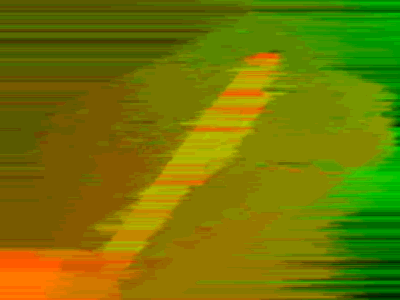

In [9]:
k = np.ones((3,3))/9
img_shift2[:,:,0] = ndimage.convolve(img_shift2[:,:,0], k, mode='reflect')
img_shift2[:,:,1] = ndimage.convolve(img_shift2[:,:,1], k, mode='reflect')
Image.fromarray((255.9*img_shift2/img_shift2.max()).astype(np.uint8))

# lab2 start

https://staff.fnwi.uva.nl/l.dorst/hz/chap11_13.pdf

In [10]:
from random import choices
from scipy.linalg import null_space

In [11]:
def is_smooth(img_shift, x, y, radius=2):
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            if np.any(img_shift[y, x] != img_shift[y+i, x+j]):
                return False
    return True


map2draw = np.zeros((img_r.shape), dtype=np.uint8)

pairs = []
rejected_pairs = []
# (X, X')
for y_r in range(30, img_r.shape[0] - 30):
    for x_r in range(30, img_r.shape[1] - 30):
        x_r3d = [x_r, y_r, 1]
        
        dot_shift = img_shift2[y_r, x_r]
        
        x_l = int(x_r - dot_shift[0])
        y_l = int(y_r - (dot_shift[1] - kv_half))
        x_l3d = [x_l, y_l, 1]
        
        if is_smooth(img_shift2, x_r, y_r):
            pairs.append([x_l3d, x_r3d])
            map2draw[y_r, x_r] = 255
        else:
            rejected_pairs.append([x_l3d, x_r3d])

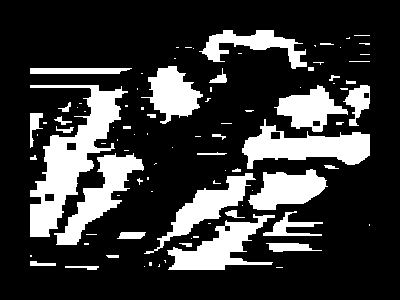

In [12]:
Image.fromarray(map2draw)

In [13]:
len(pairs)

26632

In [14]:
len(rejected_pairs)

54968

In [15]:
Boundary = 1e-4
bestF = None
bestScore = 0

all_right = np.array([i[1] for i in pairs])
all_left = np.array([i[0] for i in pairs])

for iteration in range(20000):
    seven_pairs = choices(pairs, k=7)
    X_big = []
    for left, right in seven_pairs:
        x_l, y_l, z_l = left
        x_r, y_r, z_r = right
        X_big.append([x_r*x_l, x_r*y_l, x_r*z_l,
                      y_r*x_l, y_r*y_l, y_r*z_l,
                      z_r*x_l, z_r*y_l, z_r*z_l])
        # на попередній лінії була помилка,
        # через яку я декілька тижнів не міг зрозуміти чого не працює.
        # вічна пам'ять моїм загиблим нервовим клітинам.
        # F
    X_big = np.array(X_big)
    null_vectors = null_space(X_big)
    f1 = null_vectors[:,0].reshape((3,3))
    f2 = null_vectors[:,1].reshape((3,3))
    
    p = np.array([
     np.linalg.det(f2),
     np.linalg.det(f2)*np.trace(np.dot(np.linalg.inv(f2), f1)),
     np.linalg.det(f1)*np.trace(np.dot(np.linalg.inv(f1), f2)),
     np.linalg.det(f1),
    # на попередній лінії була помилка,
    # через яку я декілька місяців не міг зрозуміти чого не працює.
    # вічна пам'ять моїм загиблим нервовим клітинам.
    # F
    ])
    coefs = np.roots(p)
    for i in coefs:
        if np.iscomplex(i):
            continue
        F = f1+float(i)*f2
        # both matrix have zero det
        score = np.sum(np.abs(np.einsum('ki,ij,kj->k', all_right, F, all_left)) < Boundary)
        if score > bestScore:
            bestScore = score
            bestF = F.copy()
            print("="*20)
            print("hit", bestScore/len(pairs))
            
            epipole = null_space(bestF, 1e-3)
            print(epipole)
            epipole = epipole/epipole[-1]
            epipole_strich = [epipole[0,0], epipole[1,0]]
            print("X:", epipole_strich[0])
            print("Y:", epipole_strich[1])

hit 0.00048813457494743166
[[0.89323948]
 [0.44956388]
 [0.0039445 ]]
X: 226.45173988695512
Y: 113.9722599581526
hit 0.0006383298287774106
[[-0.99909279]
 [-0.0424343 ]
 [-0.00359596]]
X: 277.83793378585153
Y: 11.800563013350729
hit 0.0007509762691498949
[[-0.94207532]
 [-0.33538446]
 [-0.00336962]]
X: 279.57886967545585
Y: 99.53175286541126
hit 0.0021402823670772005
[[0.77893644]
 [0.62709545]
 [0.00305315]]
X: 255.12532159105038
Y: 205.39279126502913
hit 0.005294382697506759
[[-0.77033442]
 [-0.63763293]
 [-0.0030228 ]]
X: 254.84110228365682
Y: 210.94095522381673
hit 0.2028011414839291
[[0.64601676]
 [0.76331519]
 [0.00350145]]
X: 184.50000000000716
Y: 218.00000000011218


/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


hit 0.23257735055572243
[[-0.98782669]
 [-0.15549124]
 [-0.00457327]]
X: 216.0000000012827
Y: 33.99999999997015
hit 0.23340342445178733
[[0.84977179]
 [0.52713116]
 [0.00454423]]
X: 187.0000000001459
Y: 116.00000000012739
hit 0.41037098227696006
[[4.63311370e-11]
 [1.00000000e+00]
 [1.20348176e-13]]
X: 384.97581449465343
Y: 8309224404742.61
hit 0.4306473415440072
[[-3.16227766e-01]
 [-9.48683298e-01]
 [ 3.44169138e-15]]
X: -91881499948589.5
Y: -275644499844585.3


## Фундаментальна матриця

In [16]:
np.round(bestF, 2)

array([[ 0.  , -0.  , -3.65],
       [ 0.  , -0.  ,  1.22],
       [ 3.65, -1.22, 30.45]])

In [17]:
bestF

array([[ 4.16936722e-16, -1.34733804e-14, -3.65396827e+00],
       [ 1.38819078e-14, -1.82389910e-16,  1.21798942e+00],
       [ 3.65396827e+00, -1.21798942e+00,  3.04497355e+01]])

In [51]:
np.save("bestF.npy", bestF)
np.save("bestScore.npy", bestScore)

In [19]:
#bestF = np.load("bestF.npy")
#bestScore = np.load("bestScore.npy")

In [20]:
#with shelve.open("lab2.db") as db:
#    #db["bestF"] = bestF
#    #db["bestScore"] = bestScore
#    bestF = db["bestF"]
#    bestScore = db["bestScore"]
#    #img_shift2 = db["img_shift2"]

## Відсоток точок, які задовольняють умову до фундаментальної матриці

In [21]:
print(round(100*bestScore/len(pairs), 2),"%")

43.06 %


## Епіполярна точка у 3-х координатах

In [28]:
epipole = null_space(bestF, 1e-3)
epipole

array([[-3.16227766e-01],
       [-9.48683298e-01],
       [ 3.44169138e-15]])

In [29]:
epipole.reshape(3)

array([-3.16227766e-01, -9.48683298e-01,  3.44169138e-15])

In [20]:
np.linalg.det(bestF)

-3.164050613480264e-19

## Ліве зображення

In [24]:
from PIL import ImageDraw

In [46]:
image2show = Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")
draw = ImageDraw.Draw(image2show)

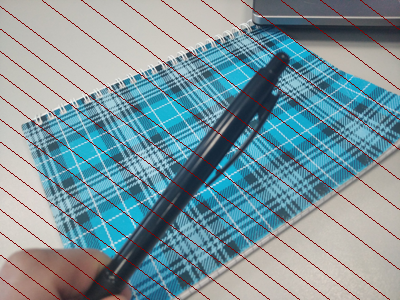

In [49]:
focus_x, focus_y = 200, 150

x_img = 400
for y_img in range(0, 300, 30):
    diff_vector = np.array([x_img, y_img, 1]) - epipole.reshape(3)
    x_line1, y_line1, z_line1 = epipole.reshape(3) + (1/3)*diff_vector
    x_line2, y_line2, z_line2 = epipole.reshape(3) + (2/3)*diff_vector

    focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
    projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
    projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    projected_diff = projected_p1 - projected_p2

    projected_p1 = projected_p1 - 10*projected_diff
    projected_p2 = projected_p2 + 10*projected_diff

    draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)

y_img = 300
for x_img in range(0, 400, 30):
    diff_vector = np.array([x_img, y_img, 1]) - epipole.reshape(3)
    x_line1, y_line1, z_line1 = epipole.reshape(3) + (1/3)*diff_vector
    x_line2, y_line2, z_line2 = epipole.reshape(3) + (2/3)*diff_vector

    focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
    projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
    projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    projected_diff = projected_p1 - projected_p2

    projected_p1 = projected_p1 - 10*projected_diff
    projected_p2 = projected_p2 + 10*projected_diff

    draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)
    
image2show

## Праве зображення

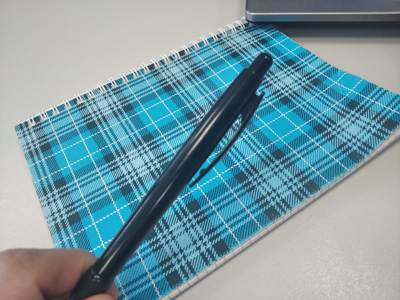

In [50]:
Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")